In [1]:
# data manipulation
import pandas as pd
import numpy as np
import scipy
import pyodbc

# visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# machine learning
from sklearn import preprocessing, utils, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, KBinsDiscretizer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, RFECV, chi2, mutual_info_classif
from xgboost import XGBClassifier

# umap 
from tqdm import tqdm
import umap


# misc.
import os
import copy

# ipython magic
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# matlpotlib properties
plt.rcParams["figure.figsize"] = 6,6
plt.rcParams["figure.dpi"] = 150
plt.rcParams['figure.max_open_warning'] = False
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# seaborn properties
sns.set(style="whitegrid")

# Read Paarth's SPADE data to get labels (generated by Viral)

In [3]:
INPUT_DIRECTORY_FILEPATH = './../Justin/StrokeReRanking/paarthwork/input/'
INPUT_DIRECTORY_FILEPATH

'./../Justin/StrokeReRanking/paarthwork/input/'

In [4]:
df = pd.read_csv(INPUT_DIRECTORY_FILEPATH + 'input.csv')
print(df.shape)
# drop the invalids
df = df[df.mod_label!='INVALID']
print(df.shape)

(398, 10)
(217, 10)


In [9]:
print(df.columns)
print(df.mod_label.value_counts())
# drop the smoking flags (unreliable)
df = df.drop(columns=['smk_flags_man', 'smk_flags_db',])
print(df.shape)

Index(['study_ids', 'ed_duration', 'ed_inp_delta', 'age_val', 'img_flags',
       'con_flags', 'smk_flags_man', 'smk_flags_db', 'elix_score',
       'mod_label'],
      dtype='object')
TTP    124
TFP     93
Name: mod_label, dtype: int64
(217, 8)


In [11]:
feature_columns_cat = ['img_flags','con_flags']
feature_columns_cont = ['ed_duration', 'ed_inp_delta', 'age_val', 'elix_score' ]
label_column = 'mod_label' 

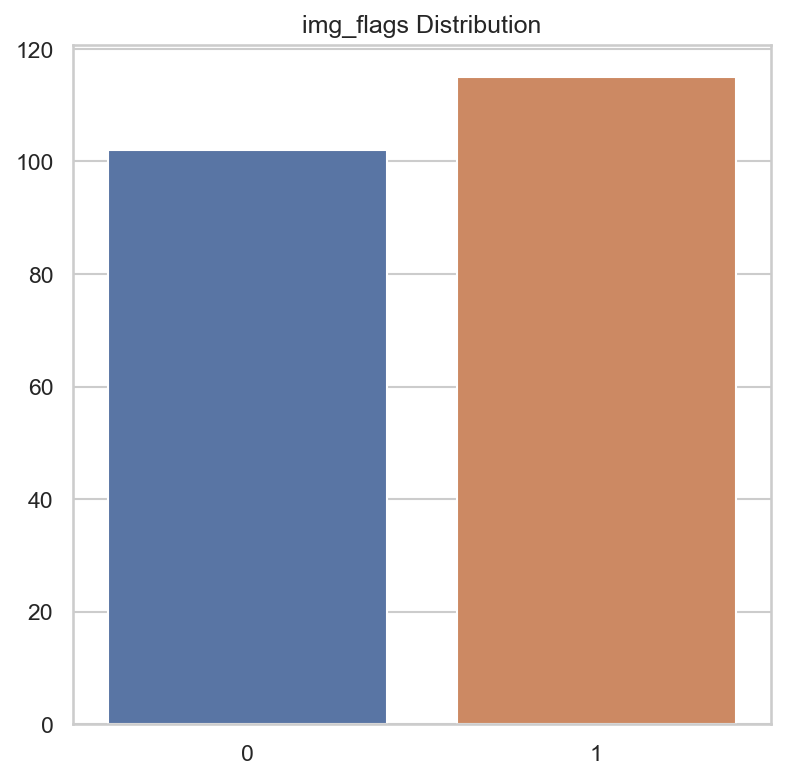

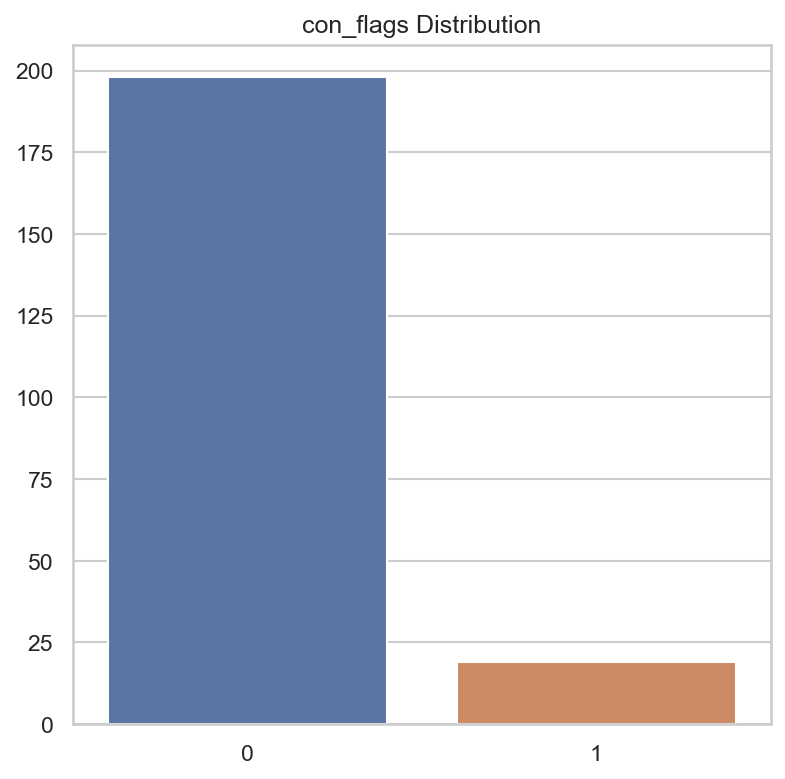

In [13]:
for col in feature_columns_cat:

    # Create figure variables
    fldist_fig, fldist_axes = plt.subplots()
    sns.countplot(data=df, x=col, ax=fldist_axes)

    # Set text
    fldist_axes.set_title(col + ' Distribution')
    fldist_axes.set_ylabel('')
    fldist_axes.set_xlabel('')
    fldist_fig.set_figheight(6)
    fldist_fig.set_figwidth(6)

    # Save figure
    #fldist_fig.savefig(os.path.join(OUTPUT_DIRECTORY_FILEPATHS['EDA'], '{}_distributionbylabel.svg'.format(col)))

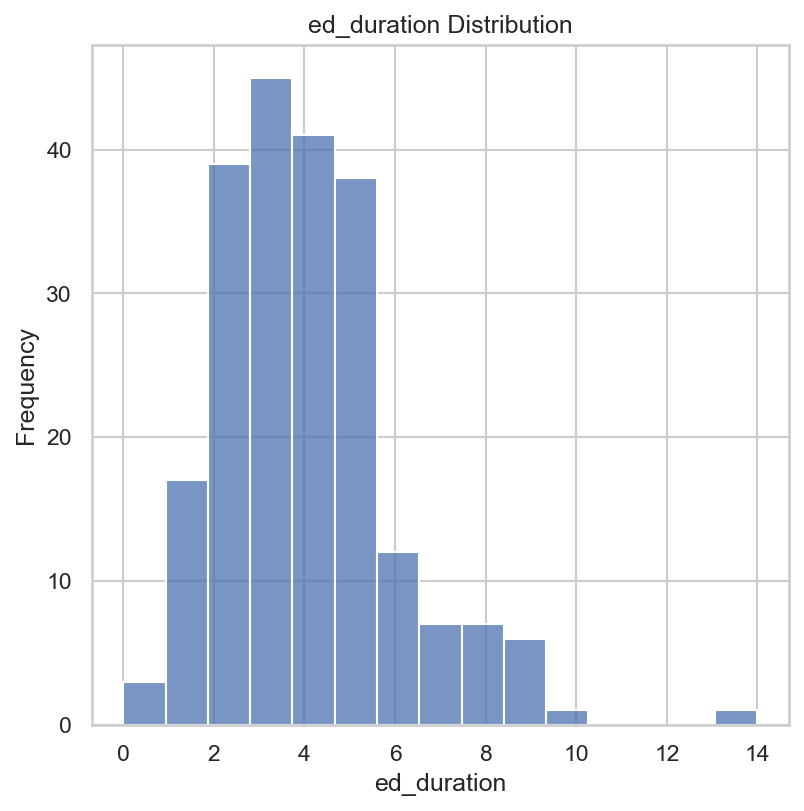

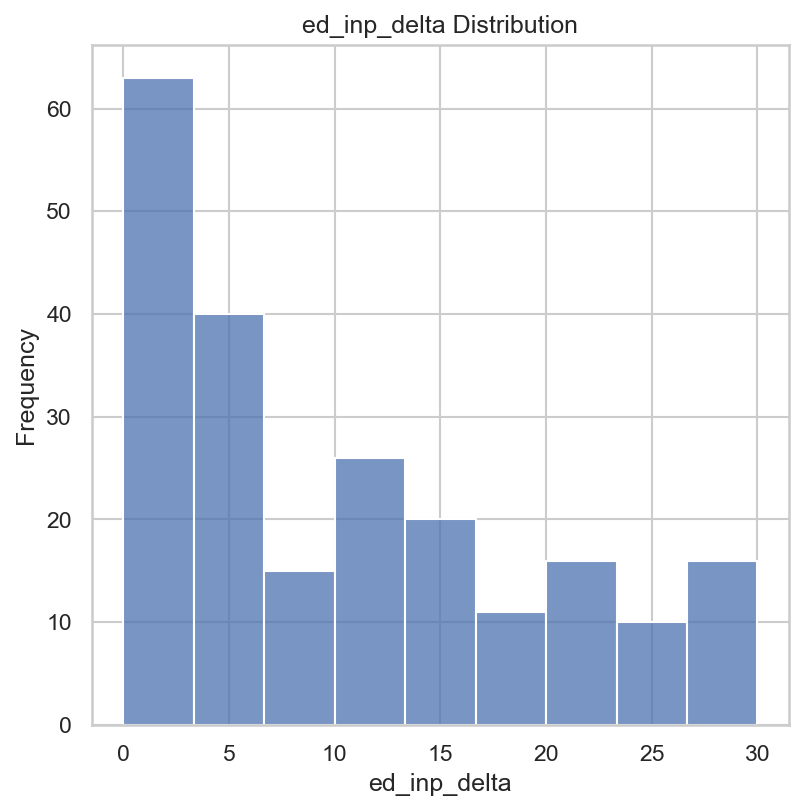

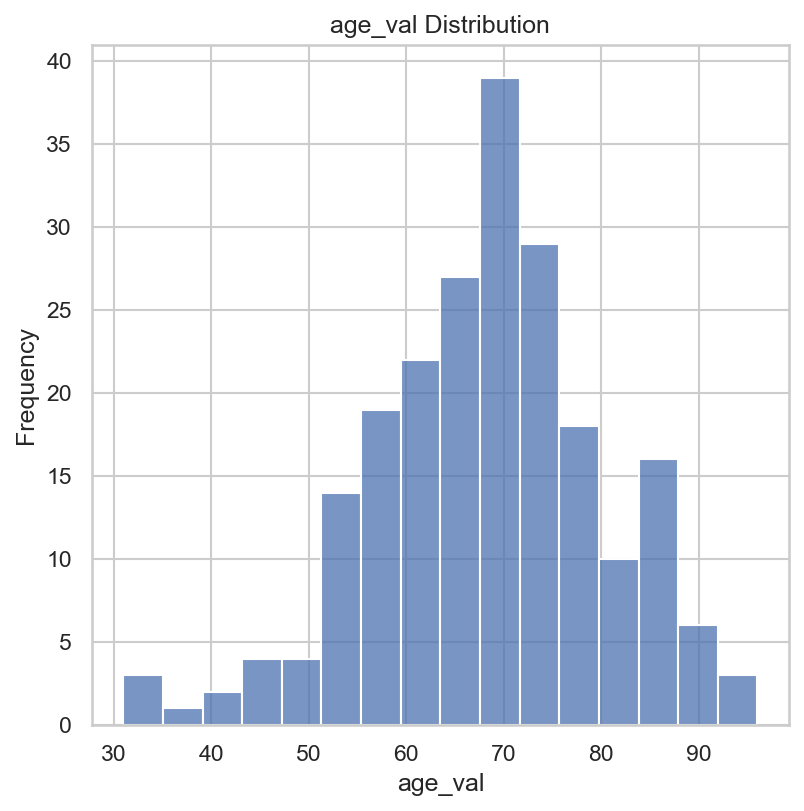

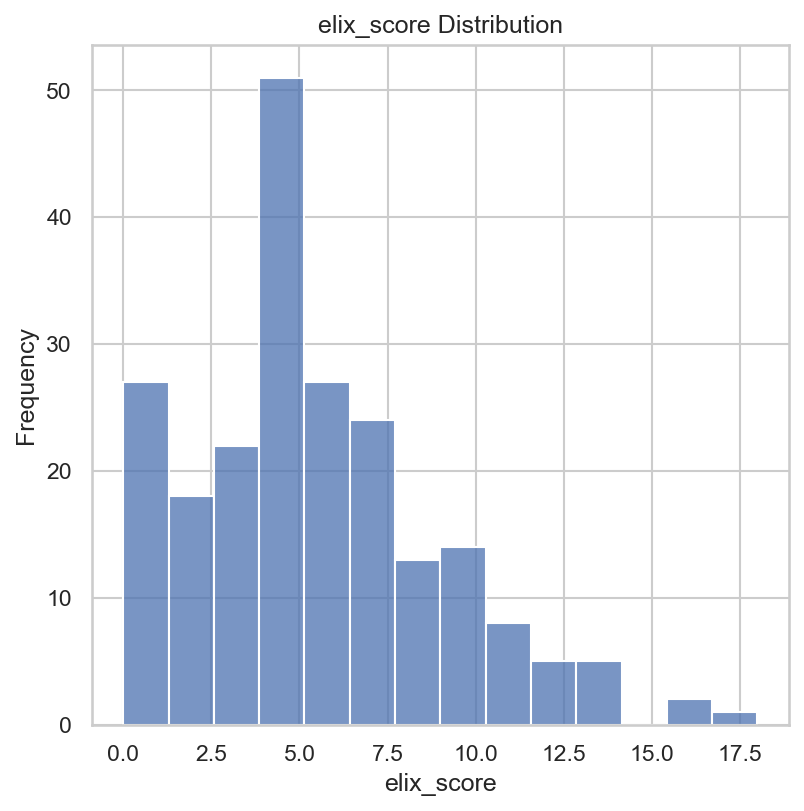

In [15]:
for col in feature_columns_cont:

    # Create figure variables
    fldist_fig, fldist_axes = plt.subplots()
    sns.histplot(data=df, x=col, ax=fldist_axes)

    # Set text
    fldist_axes.set_title(col + ' Distribution')
    fldist_axes.set_ylabel('Frequency')
    fldist_axes.set_xlabel(col)
    fldist_fig.set_figheight(6)
    fldist_fig.set_figwidth(6)

    # Save figure
    #fldist_fig.savefig(os.path.join(OUTPUT_DIRECTORY_FILEPATHS['EDA'], '{}_distributionbylabel.svg'.format(col)))

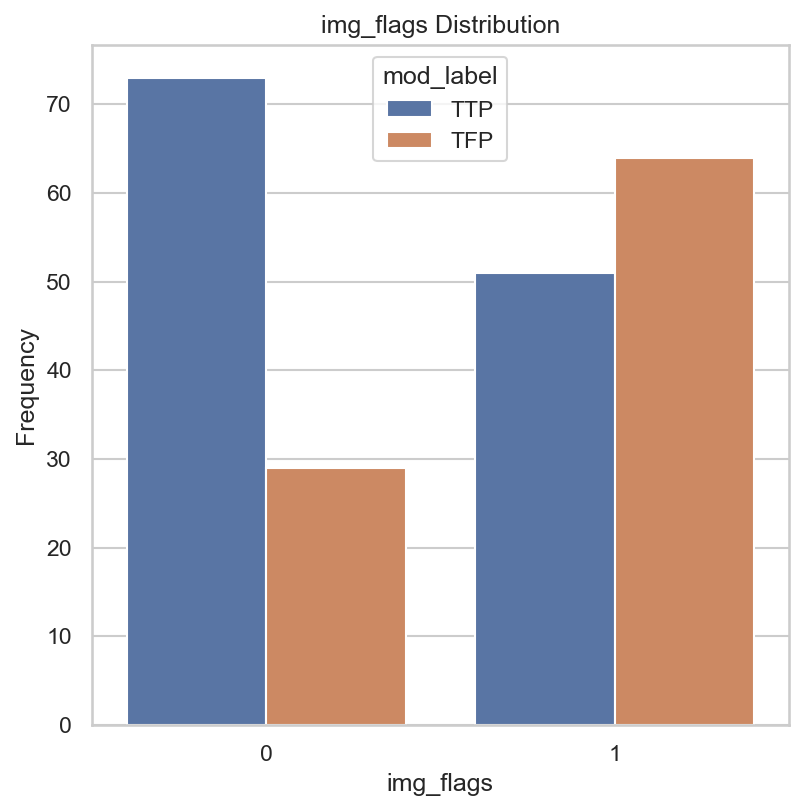

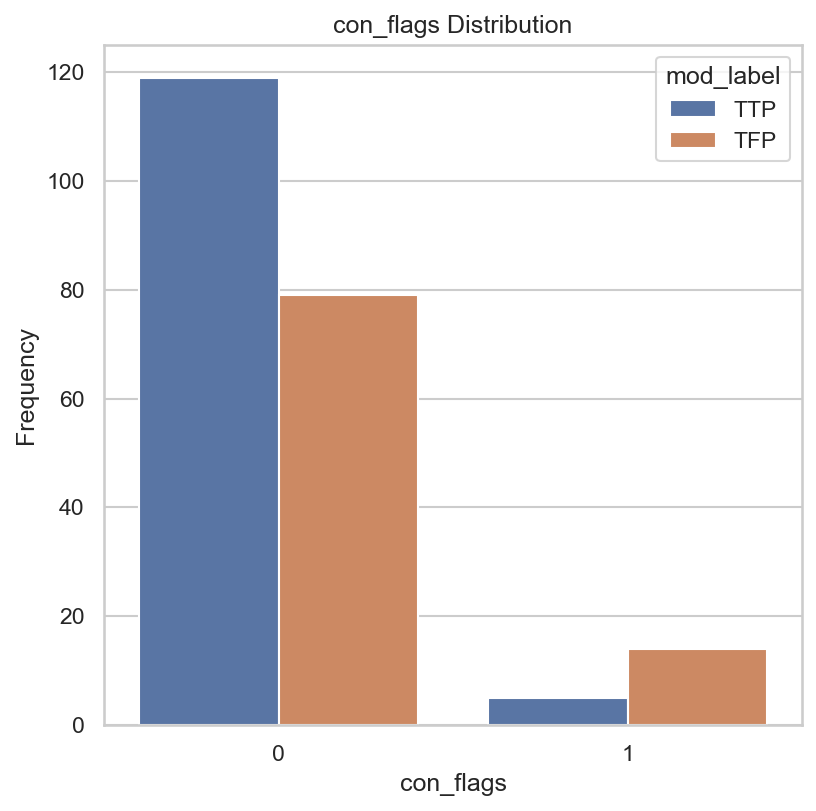

In [16]:
for col in feature_columns_cat:

    # Create figure variables
    fldist_fig, fldist_axes = plt.subplots()
    sns.countplot(data=df, x=col, hue=label_column, ax=fldist_axes)

    # Set text
    fldist_axes.set_title(col + ' Distribution')
    fldist_axes.set_ylabel('Frequency')
    fldist_axes.set_xlabel(col)
    fldist_fig.set_figheight(6)
    fldist_fig.set_figwidth(6)

    # Save figure
    #fldist_fig.savefig(os.path.join(OUTPUT_DIRECTORY_FILEPATHS['EDA'], '{}_distributionbylabel.svg'.format(col)))

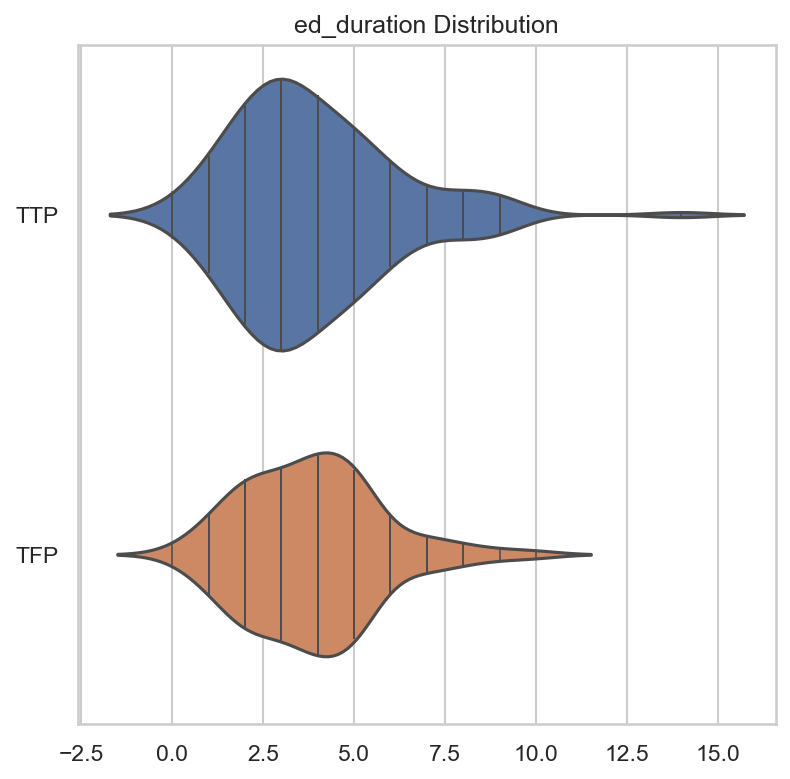

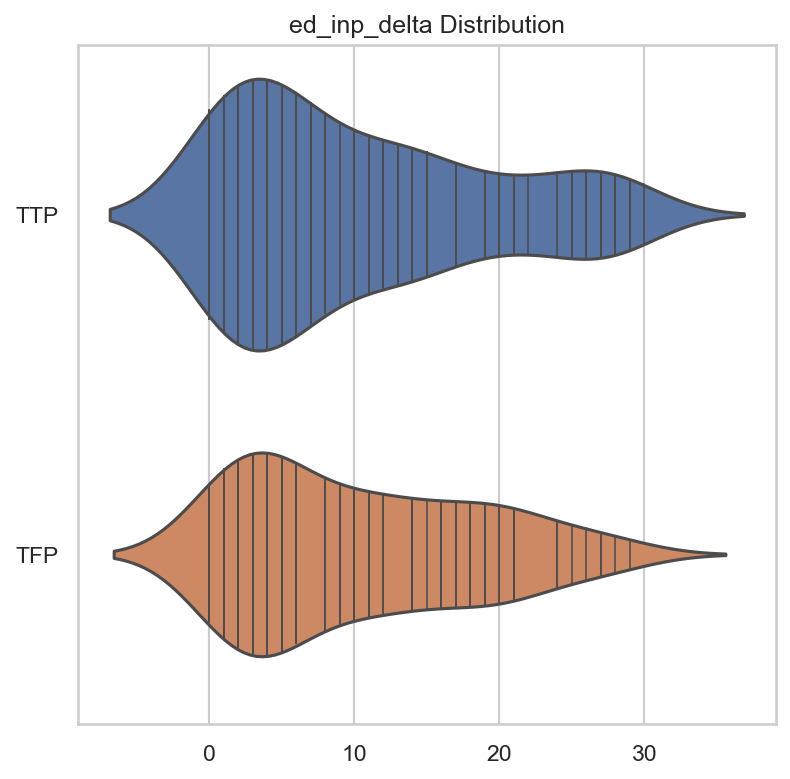

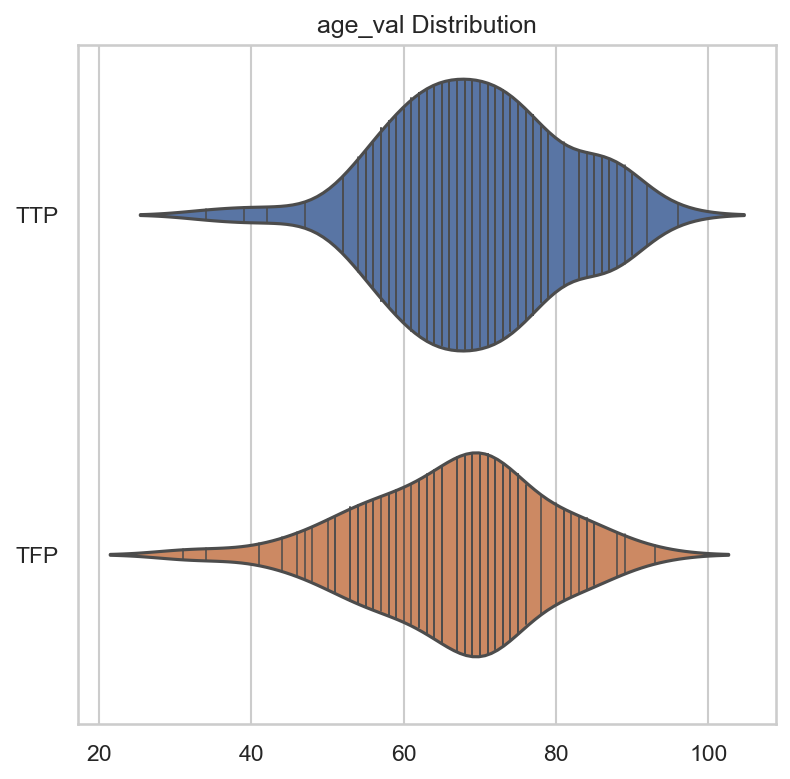

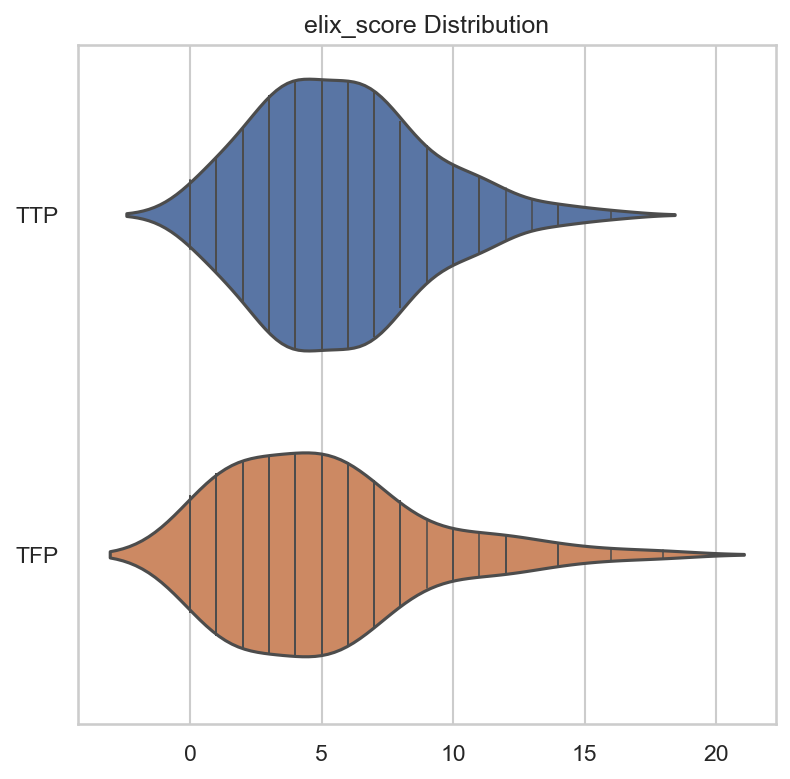

In [17]:
for col in feature_columns_cont:

    # Create figure variables
    fldist_fig, fldist_axes = plt.subplots()
    sns.violinplot(data=df, x=col, y=label_column, scale='count', inner='stick', ax=fldist_axes)

    # Set text
    fldist_axes.set_title(col + ' Distribution')
    fldist_axes.set_ylabel('')
    fldist_axes.set_xlabel('')
    fldist_fig.set_figheight(6)
    fldist_fig.set_figwidth(6)

    # Save figure
    #fldist_fig.savefig(os.path.join(OUTPUT_DIRECTORY_FILEPATHS['EDA'], '{}_distributionbylabel.svg'.format(col)))



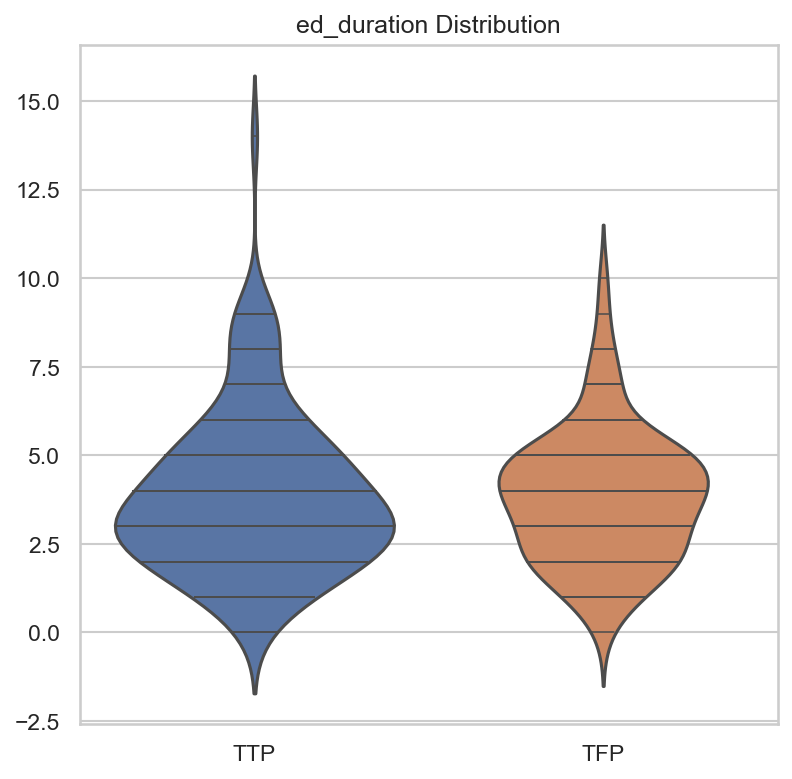

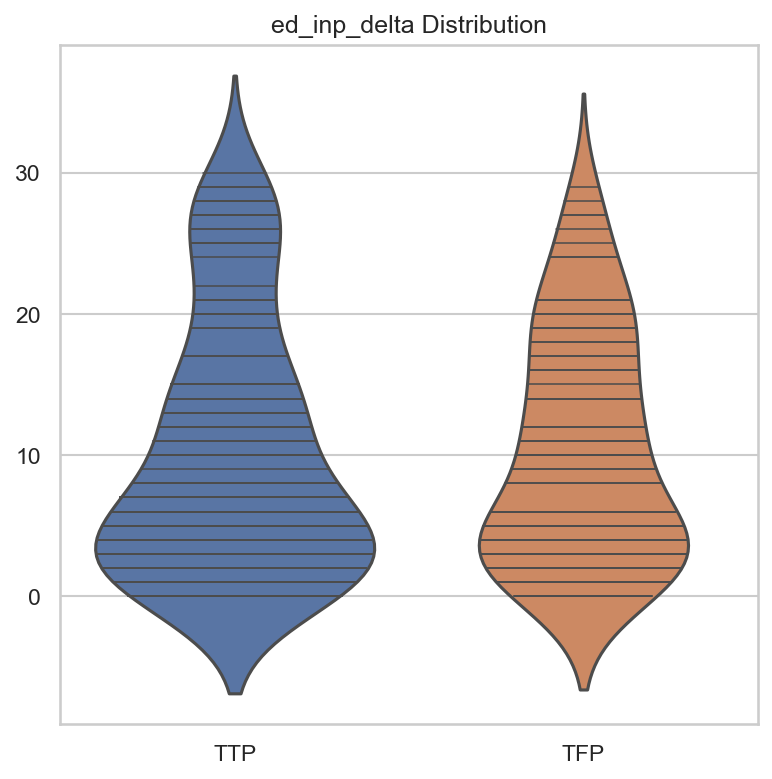

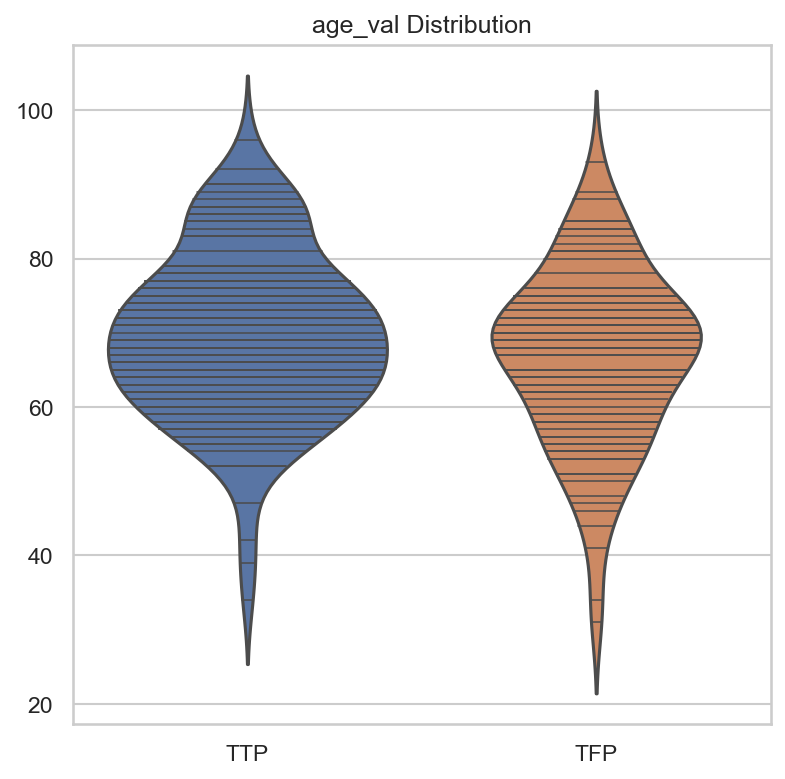

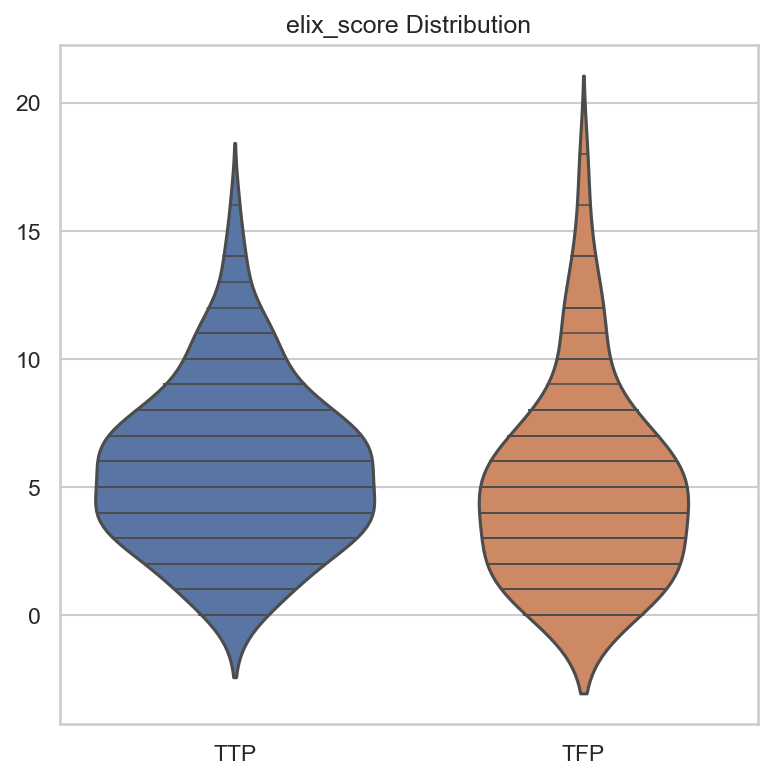

In [27]:
for col in feature_columns_cont:

    # Create figure variables
    fldist_fig, fldist_axes = plt.subplots()
    sns.violinplot(data=df, x=label_column, y=col, scale='count', inner='stick', ax=fldist_axes)

    # Set text
    fldist_axes.set_title(col + ' Distribution')
    fldist_axes.set_ylabel('')
    fldist_axes.set_xlabel('')
    fldist_fig.set_figheight(6)
    fldist_fig.set_figwidth(6)

    # Save figure
    #fldist_fig.savefig(os.path.join(OUTPUT_DIRECTORY_FILEPATHS['EDA'], '{}_distributionbylabel.svg'.format(col)))

In [26]:
# do a ttest on the categorical columns

from scipy.stats import ttest_ind, mannwhitneyu

for col in feature_columns_cat:
    tstat, pval = ttest_ind(df[df.mod_label=='TFP'][col],df[df.mod_label=='TTP'][col] )
    if pval < 0.05:
        print(col,pval)

# do a MannWhitney test on continuous columns

for col in feature_columns_cont:
    tstat, pval = mannwhitneyu(df[df.mod_label=='TFP'][col],df[df.mod_label=='TTP'][col] )
    if pval < 0.05:
        print(col,pval)

img_flags 4.1342553073177336e-05
con_flags 0.004330418033418919
elix_score 0.016662037986014025


(217, 2)


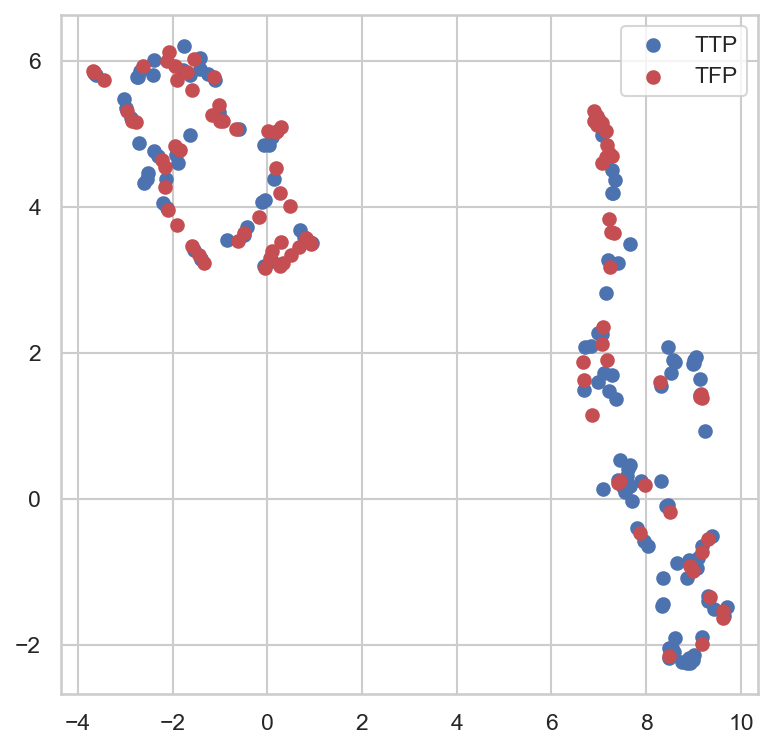

In [63]:
# do a UMAP plot of the data

X = df[feature_columns_cat+feature_columns_cont].values
y = df[label_column]

# scale the data
scaler = StandardScaler()
sX = scaler.fit_transform(X)

reducer = umap.UMAP(n_neighbors=10,min_dist=0.0,metric='correlation',random_state=4)
embedding = reducer.fit_transform(sX)
print(embedding.shape)

plt.scatter(embedding[y=='TTP',0],embedding[y=='TTP',1],c='b',label='TTP')
plt.scatter(embedding[y=='TFP',0],embedding[y=='TFP',1],c='r',label='TFP')
plt.legend(loc='upper right')

In [64]:
# do a kmeans cluster
from sklearn.cluster import KMeans

clust = KMeans(n_clusters=2)
clust.fit(embedding)

for i in range(2):
    print('Cluster :',i)
    print(y[clust.labels_==i].value_counts())

Cluster : 0
TFP    51
TTP    49
Name: mod_label, dtype: int64
Cluster : 1
TTP    75
TFP    42
Name: mod_label, dtype: int64


In [ ]:
display(df[clust.labels_==0].describe())
display(df[clust.labels_==1].describe())

# Get Li's fresh data on RF_SPADE trigger

In [2]:
conn = pyodbc.connect("DRIVER={SQL Server};SERVER=VHACDWRB03;DATABASE=ORD_Singh_201911038D")

In [3]:
info_str = "select * from information_schema.tables where table_name like '_A00_RFSPADE%'"
info_df = pd.read_sql(sql=info_str,con=conn)
info_df

,TABLE_CATALOG,TABLE_SCHEMA,TABLE_NAME,TABLE_TYPE
0,ORD_Singh_201911038D,Dflt,_A00_RFSPADETrgPos_Y201617_05_04_Rad,BASE TABLE
1,ORD_Singh_201911038D,Dflt,_A00_RFSPADETrgPos_Y201617_30_Note,BASE TABLE
2,ORD_Singh_201911038D,Dflt,_A00_RFSPADETrgPos_Y201617_12_ICD,BASE TABLE
3,ORD_Singh_201911038D,Dflt,_A00_RFSPADETrgPos_Y201617_14_Vital,BASE TABLE
4,ORD_Singh_201911038D,Dflt,_A00_RFSPADETrgPos_Y201617_06_Med_04_RxOutpat,BASE TABLE
5,ORD_Singh_201911038D,Dflt,_A00_RFSPADETrgPos_Y201617_02_04_Demorgraphics,BASE TABLE
6,ORD_Singh_201911038D,Dflt,_A00_RFSPADETrgPos_Y201617_06_Med_05_BCMA_Disp...,BASE TABLE
7,ORD_Singh_201911038D,Dflt,_A00_RFSPADETrgPos_Y201617_16_HealthFactor,BASE TABLE
8,ORD_Singh_201911038D,Dflt,_A00_RFSPADETrgPos_Y201617_06_Med_07_NonVAMed,BASE TABLE
9,ORD_Singh_201911038D,Dflt,_A00_RFSPADETrgPos_Y201617_06_Med_08_AllMed,BASE TABLE


In [4]:
# read all the tables into pandas tables
tables = {}
for tname in info_df.TABLE_NAME:
    query_str = "select * from  " + str("Dflt.")+ str(tname)
    table_df = pd.read_sql(sql=query_str,con=conn)
    tables[tname.split('_')[-1]] = table_df

In [5]:
tables.keys()

dict_keys(['Rad', 'Note', 'ICD', 'Vital', 'RxOutpat', 'Demorgraphics', 'DispensedDrug', 'HealthFactor', 'NonVAMed', 'AllMed', 'cohort', 'Consult', 'Lab'])

# Plan A
- get cohort, RxOutpat, Consult, ICD for initial analysis

In [57]:
cohort = tables['cohort'].copy()
ICDs = tables['ICD'].copy()
RxOutpat = tables['RxOutpat'].copy()
consult = tables['Consult'].copy()

demog = tables['Demorgraphics'].copy()
notes = tables['Note'].copy()

print(cohort.columns)
print(ICDs.columns)
print(RxOutpat.columns)
print(consult.columns)

print(demog.columns)
print(notes.columns)

# convert date time fields to pandas format
datefields = ['EDStartDateTime', 'EDEndDateTime','AdmitDateTime', 'DischargeDateTime']
for datef in datefields:
    cohort[datef] = pd.to_datetime(cohort[datef]) 
ICDs.DiagDateTime = pd.to_datetime(ICDs.DiagDateTime)
RxOutpat.DispensedDate = pd.to_datetime(RxOutpat.DispensedDate)
consult.RequestDateTime = pd.to_datetime(consult.RequestDateTime)

demog.DOB = pd.to_datetime(demog.DOB)
notes.EntryDateTime = pd.to_datetime(notes.EntryDateTime)

Index(['patientSSN', 'EDStartDateTime', 'EDEndDateTime', 'EDVisitReason',
       'AdmitDateTime', 'DischargeDateTime', 'outpatVisitSID', 'inpatientsid',
       'patientsid', 'sta3n', 'studyID'],
      dtype='object')
Index(['PatientSSN', 'DiagDateTime', 'ICD', 'ICDDiagnosis', 'IsPrincipalDiag'], dtype='object')
Index(['PatientSSN', 'DrugClassCode', 'LocalDrugNameWithDose', 'NDC', 'Sta3n',
       'PatientSID', 'RxOutpatSID', 'LocalDrugSID', 'RxOutpatFillSID',
       'DispensedDate', 'Qty', 'QtyNumeric', 'DaysSupply'],
      dtype='object')
Index(['PatientSSN', 'Sta3n', 'PatientSID', 'RequestDateTime',
       'CPRSOrderResultsDateTime', 'requestType', 'ConStopCode',
       'ConStopCodeName', 'ToRequestServiceName', 'ConsultSID',
       'ToRequestserviceSID'],
      dtype='object')
Index(['patientSSN', 'IndexDateTime', 'DOB', 'Gender', 'Ethnicity', 'Race'], dtype='object')
Index(['PatientSSN', 'EntryDateTime', 'TIUDocumentSID', 'TIUStandardTitle',
       'ReportText', 'Sta3n', 'PatientSID

array([[<AxesSubplot:title={'center':'visit_count'}>]], dtype=object)

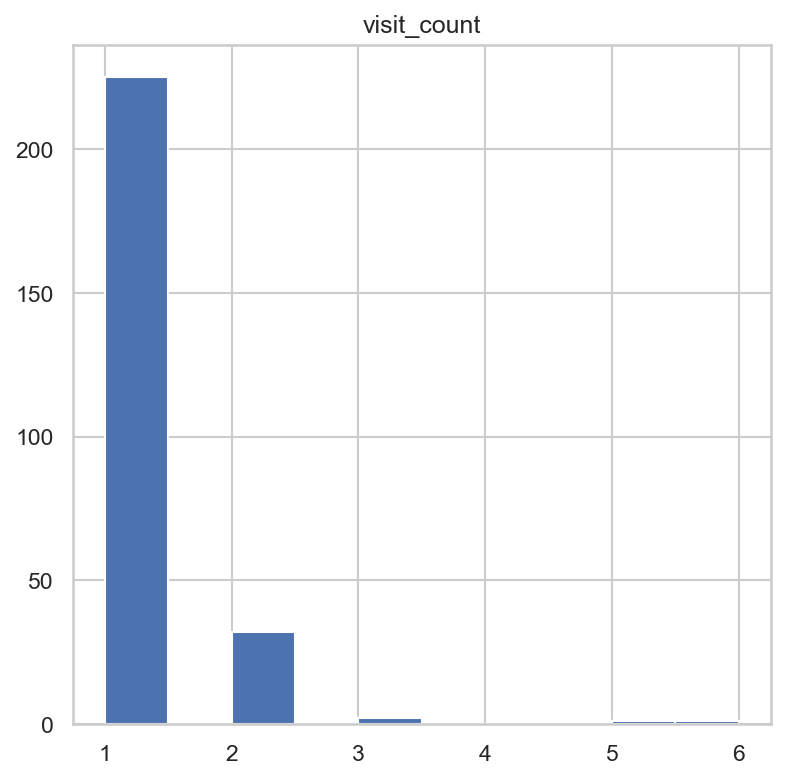

In [20]:
visits = {}
for pid in cohort.patientSSN:
    # what are index visits for patient?
    cohort_rec = cohort[cohort.patientSSN==pid]
    visits[pid] = cohort_rec.shape[0]
pd.DataFrame.from_dict(visits,orient='index',columns=['visit_count']).hist()

In [52]:
# pre-process the drugs and only include drug classes of interest
va_drug_classes = ['BL110','BL115','BL117','CV000','CV100','CV150','CV200','CV350','CV400','CV490','CV500',
                  'CV701','CV702','CV704','CV709','CV800','CV805','CV806','HS500','HS501','HS502','HS503','HS509']
va_super_category = ['anticoagulant','lytic','antiplatelet']+ ['antihypertensive']*4 +\
                    ['cholesterol'] + ['antihypertensive']*10+['diabetes']*5

drug_df = pd.DataFrame(columns=['DrugClass','SuperCategory'])
drug_df['DrugClass'] = np.array(va_drug_classes)
drug_df['SuperCategory'] = np.array(va_super_category)

In [54]:
RxOutpat_lim = RxOutpat[RxOutpat.DrugClassCode.isin(va_drug_classes)]
print(RxOutpat.shape,RxOutpat_lim.shape)

(74746, 13) (21500, 13)


# helper functions for extracting relevant information

In [124]:
def get_demographics(demo):
    DOB, gender, ethnicity, race = demo['DOB'].values[0],demo['Gender'].values[0],\
                                   demo['Ethnicity'].values[0],demo['Race'].values[0]
    return DOB, gender, ethnicity, race

def get_neuro_consults(consult_rec,cohort_rec):
    consults_at_ED = consult_rec[(consult_rec.RequestDateTime >= cohort_rec.iloc[0].EDStartDateTime) &
                       (consult_rec.RequestDateTime <= cohort_rec.iloc[0].EDEndDateTime)]
    if consults_at_ED.shape[0] == 0:
        num_neuro_consult_at_ED, num_MRI_consult_at_ED = 0,0
    else:
        neuro_consults = consult_at_ED[consults_at_ED.ConStopCodeName.str.contains('NEUR')]
        num_neuro_consult_at_ED = neuro_consults.shape[0]
        MRI_consults = consult_at_ED[consults_at_ED.ConStopCodeName.str.contains('MRI')]
        num_MRI_consult_at_ED = MRI_consults.shape[0]
        
    consults_at_hosp = consult_rec[(consult_rec.RequestDateTime >= cohort_rec.iloc[0].AdmitDateTime) &
                       (consult_rec.RequestDateTime <= cohort_rec.iloc[0].DischargeDateTime)]
    if consults_at_hosp.shape[0] == 0:
        num_neuro_consult_at_hosp, num_MRI_consult_at_hosp = 0,0
    else:
        neuro_consults = consults_at_hosp[consults_at_hosp.ConStopCodeName.str.contains('NEUR')]
        num_neuro_consult_at_hosp = neuro_consults.shape[0]
        MRI_consults = consults_at_hosp[consults_at_hosp.ConStopCodeName.str.contains('MRI')]
        num_MRI_consult_at_hosp = MRI_consults.shape[0]
    return num_neuro_consult_at_ED, num_MRI_consult_at_ED,num_neuro_consult_at_hosp, num_MRI_consult_at_hosp

relevant_ICDs = ['G45','I63','I69','I10','E11','I25']

def strip_suffix_ICD(ICD):
    return ICD.split('.')[0]

def make_count_df(vc,relevant_items):
    df = pd.DataFrame(columns=relevant_items)
    
    for c in relevant_items:
        if c in vc:
            df.loc[0,c] = vc[c]
        else:
            df.loc[0,c] = 0
    return df

def get_ICD_stats(ICD_rec,cohort_rec):
    ICD_at_ED = ICD_rec[(ICD_rec.DiagDateTime >= cohort_rec.iloc[0].EDStartDateTime) &
                  (ICD_rec.DiagDateTime <= cohort_rec.iloc[0].EDEndDateTime) ]['ICD']
    ICD_at_ED = ICD_at_ED.apply(strip_suffix_ICD)
    ICD_at_ED_count = ICD_at_ED[ICD_at_ED.isin(relevant_ICDs)].value_counts()
    
    ICD_at_hosp = ICD_rec[(ICD_rec.DiagDateTime >= cohort_rec.iloc[0].AdmitDateTime) &
                  (ICD_rec.DiagDateTime <= cohort_rec.iloc[0].DischargeDateTime) ]['ICD']
    ICD_at_hosp = ICD_at_hosp.apply(strip_suffix_ICD)
    ICD_at_hosp_count = ICD_at_hosp[ICD_at_hosp.isin(relevant_ICDs)].value_counts()
    
    # convert count series into full dataframes
    
    return make_count_df(ICD_at_ED_count,relevant_ICDs),make_count_df(ICD_at_hosp_count,relevant_ICDs)

In [130]:
def get_RxOutpat(RxOutpat_rec,cohort_rec):
    Rx_at_ED = RxOutpat_rec[(RxOutpat_rec.DispensedDate >= cohort_rec.iloc[0].EDStartDateTime) &
                  (RxOutpat_rec.DispensedDate <= cohort_rec.iloc[0].EDEndDateTime) ]['DrugClassCode']
    
    Rx_at_ED_count = Rx_at_ED[Rx_at_ED.isin(va_drug_classes)].value_counts()
    
    Rx_at_hosp = RxOutpat_rec[(RxOutpat_rec.DispensedDate >= cohort_rec.iloc[0].AdmitDateTime) &
                  (RxOutpat_rec.DispensedDate <= cohort_rec.iloc[0].DischargeDateTime) ]['DrugClassCode']
   
    Rx_at_hosp_count = Rx_at_hosp[Rx_at_hosp.isin(va_drug_classes)].value_counts()
    return make_count_df(Rx_at_ED_count,va_drug_classes),make_count_df(Rx_at_hosp_count,va_drug_classes)

In [ ]:
cnt = 0
for pid in cohort.patientSSN:
    # what are index visits for patient?
    cohort_rec = cohort[cohort.patientSSN==pid]
    if cohort_rec.shape[0] == 1:
        display(cohort_rec)
        consult_rec = consult[consult.PatientSSN==pid].sort_values(by='RequestDateTime')
        ICD_rec = ICDs[ICDs.PatientSSN==pid].sort_values(by='DiagDateTime')
        RxOutpat_rec = RxOutpat_lim[RxOutpat_lim.PatientSSN==pid].sort_values(by='DispensedDate')
        
        demog_rec = demog[demog.patientSSN==pid]
        
        
        ed_duration_hrs =   (cohort_rec.EDEndDateTime - cohort_rec.EDStartDateTime).dt.seconds/3600
        time_to_admit_days = (cohort_rec.AdmitDateTime - cohort_rec.EDEndDateTime).dt.days
        
        DOB, gender, ethnicity, race = get_demographics(demog_rec)
        num_neuro_consult_at_ED, num_MRI_consult_at_ED,num_neuro_consult_at_hosp, num_MRI_consult_at_hosp = \
            get_neuro_consults(consult_rec,cohort_rec)
        ICD_at_ED, ICD_at_hosp = get_ICD_stats(ICD_rec,cohort_rec)
        Rx_at_ED, Rx_at_hosp = get_RxOutpat(RxOutpat_rec,cohort_rec)
        
        print('DOB = ',DOB, 'gender= ', gender, ' race = ', race, 'ethnicity = ', ethnicity)
        print('ED duration in hours: ', ed_duration_hrs.values, ' Time to admit in days: ',time_to_admit_days.values)
        print('Number of consults at ED: ',  num_neuro_consult_at_ED, num_MRI_consult_at_ED)
        print('Number of consults at hosp: ', num_neuro_consult_at_hosp, num_MRI_consult_at_hosp )
        print('ICDs at ED:')
        display(ICD_at_ED)
        print('ICDs at hosp:')
        display(ICD_at_hosp)
        print('Rx at ED:')
        display(Rx_at_ED)
        print('Rx at hosp:')
        display(Rx_at_hosp)
       
        if cnt > 5:
            break
        cnt += 1

In [ ]:
notes_rec = notes[notes.PatientSSN==pid].sort_values(by='EntryDateTime')
display(notes_rec[(notes_rec.EntryDateTime >= cohort_rec.iloc[0].EDStartDateTime) &
                  (notes_rec.EntryDateTime <= cohort_rec.iloc[0].EDEndDateTime) ]['ReportText'])
display(notes_rec[(notes_rec.EntryDateTime >= cohort_rec.iloc[0].AdmitDateTime) &
                  (notes_rec.EntryDateTime <= cohort_rec.iloc[0].DischargeDateTime) ]['ReportText'])

# For every encounter (single encounters only), look at
- demographics: age, race, ethnicity, gender
- ED duration
- days to admission from index visit
- length of hospitalization
- number of consults ordered during ED visit (neuro consult + MRI)
- number of consults ordered during hospital visit (neuro consult + MRI)
- ICD code of discharge after ED visit (stroke-related) and other
- ICD code (stroke-related) after hospital visit
- other ICD codes after hospital visit (number)
- meds prescribed after ED visit (super-class)
- meds prescribed after Hospitalization (super-class)



# Exploratory analysis (demographic table)
- extract age, gender, race ethnicity

<AxesSubplot:xlabel='Ethnicity', ylabel='index'>

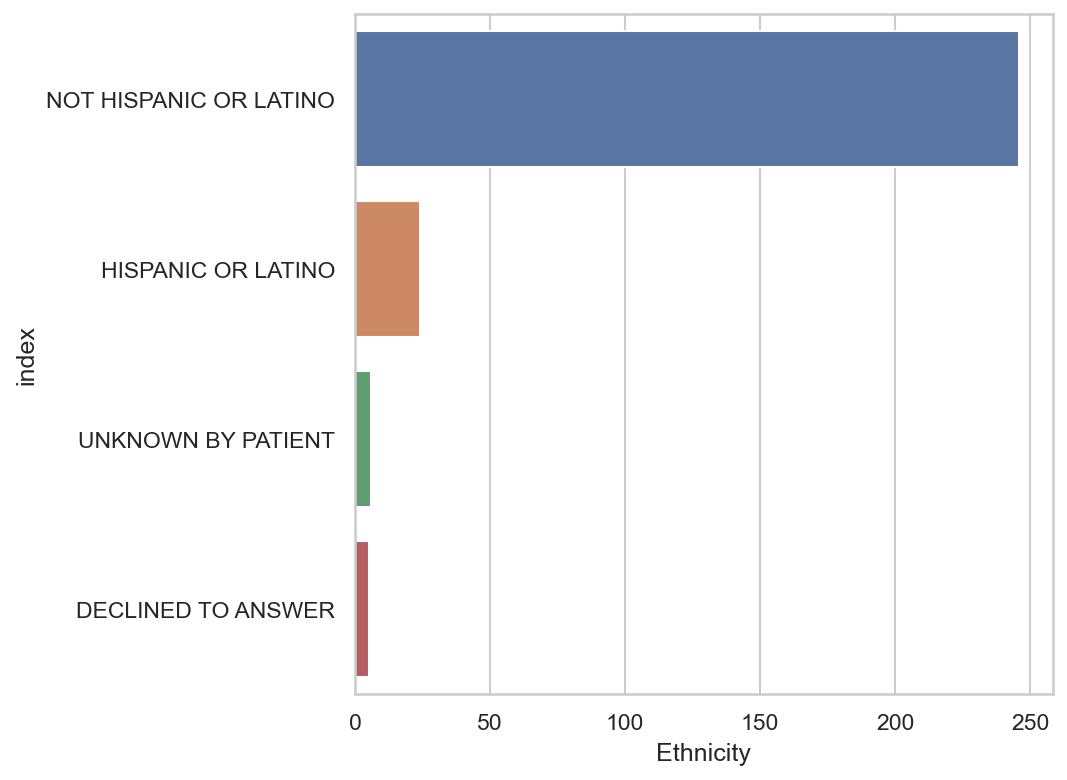

In [106]:
demog = tables['Demorgraphics']

eth_counts = demog.Ethnicity.value_counts().reset_index()
sns.barplot(y='index',x='Ethnicity',data=eth_counts)


<AxesSubplot:xlabel='Race', ylabel='index'>

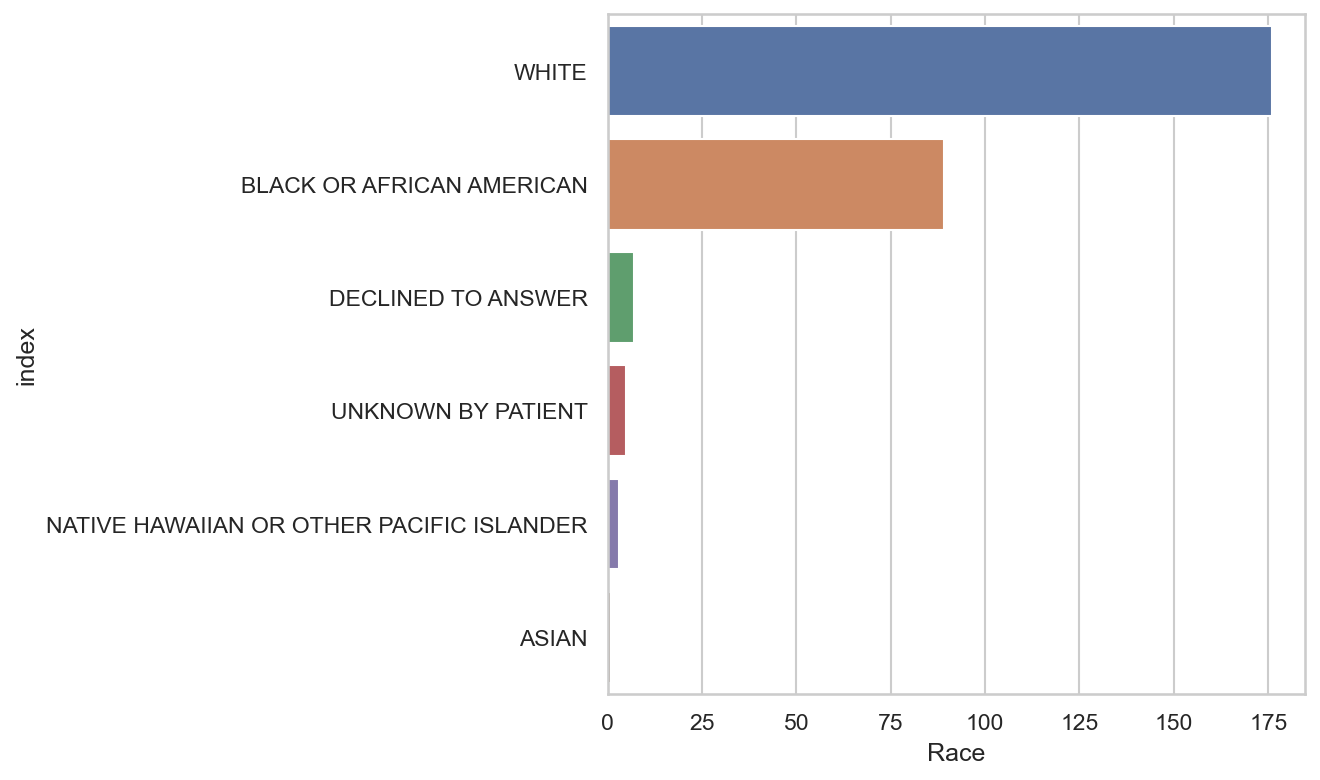

In [105]:
race_counts = demog.Race.value_counts().reset_index()
sns.barplot(y='index',x='Race',data=race_counts)

<AxesSubplot:xlabel='Gender', ylabel='index'>

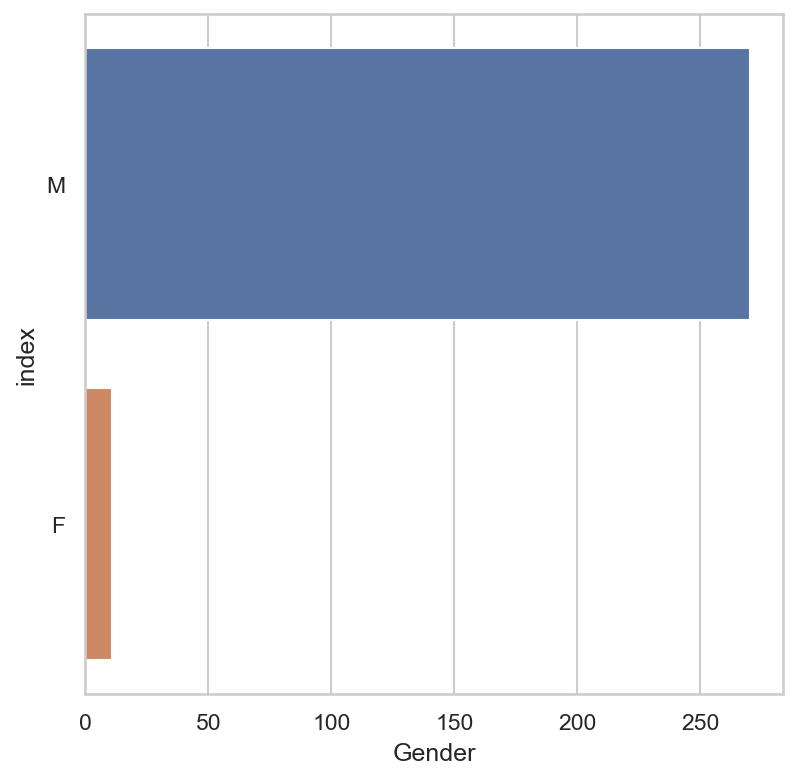

In [108]:
gender_counts = demog.Gender.value_counts().reset_index()
sns.barplot(y='index',x='Gender',data=gender_counts)

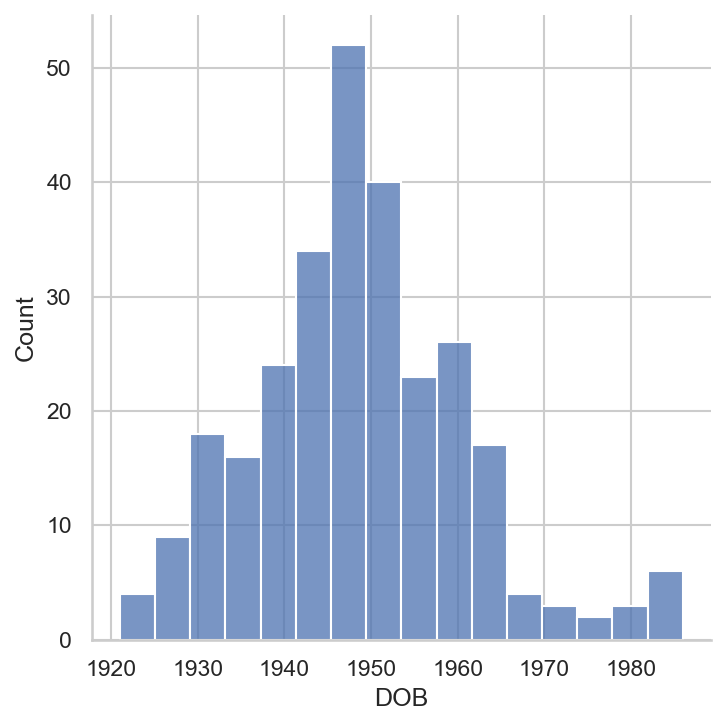

In [114]:
demog.DOB = pd.to_datetime(demog.DOB)
sns.displot(x=demog.DOB.dt.year)

# Discharge diagnosis at index ED visit
- index ED visit is in cohort table
- ICDs are in ICD table
- find the ICDs associated with that index visit discharge

In [ ]:
cohort = tables['cohort'].copy()
ICDs = tables['ICD'].copy()
print(cohort.columns)
print(ICDs.columns)

# convert date time fields to pandas format
datefields = ['EDStartDateTime', 'EDEndDateTime','AdmitDateTime', 'DischargeDateTime']
for datef in datefields:
    cohort[datef] = pd.to_datetime(cohort[datef]) 
ICDs.DiagDateTime = pd.to_datetime(ICDs.DiagDateTime)

# find index visit for each patient
cohort['time_to_admit_days'] = (cohort.AdmitDateTime - cohort.EDEndDateTime).dt.days
index_visit_df = pd.DataFrame(columns=['patientSSN','EDStartDateTime','EDEndDateTime','AdmitDateTime','DischargeDateTime'])
c = 0
for pid in set(cohort.patientSSN):
    rec = cohort[cohort.patientSSN==pid].sort_values(by='AdmitDateTime')
    if rec.shape[0] == 1: # easy case
        index_visit_df.loc[c] = [pid,rec.iloc[0]['EDStartDateTime'],
                                 rec.iloc[0]['EDEndDateTime'],rec.iloc[0]['AdmitDateTime'],
                                 rec.iloc[0]['DischargeDateTime']]
        c = c+1
    if rec.shape[0] == 2: 
        if rec.iloc[0]['EDStartDateTime'] == rec.iloc[1]['EDStartDateTime']: # escalation of care scenario
            ttime = (rec.iloc[1]['AdmitDateTime'] - rec.iloc[0]['DischargeDateTime'])/np.timedelta64(1,'h')
            if ttime < 1:
                index_visit_df.loc[c] = [pid,rec.iloc[0]['EDStartDateTime'],
                                 rec.iloc[0]['EDEndDateTime'],rec.iloc[0]['AdmitDateTime'],
                                 rec.iloc[1]['DischargeDateTime']]
                c = c+1
        else: # different ED visits lead to same hospitalization
            if rec.iloc[0]['AdmitDateTime'] == rec.iloc[1]['AdmitDateTime']:
                # pick the earlier one
                 rec = cohort[cohort.patientSSN==pid].sort_values(by='EDStartDateTime')
                 index_visit_df.loc[c] = [pid,rec.iloc[0]['EDStartDateTime'],
                                 rec.iloc[0]['EDEndDateTime'],rec.iloc[0]['AdmitDateTime'],
                                 rec.iloc[0]['DischargeDateTime']]
                 c = c+1
            else: # different ED visits lead to different hospitalizations
                #display(rec[['EDStartDateTime','AdmitDateTime','DischargeDateTime','time_to_admit_days']])
                index_visit_df.loc[c] = [pid,rec.iloc[0]['EDStartDateTime'],
                                 rec.iloc[0]['EDEndDateTime'],rec.iloc[0]['AdmitDateTime'],
                                 rec.iloc[0]['DischargeDateTime']]
                c = c+1
                index_visit_df.loc[c] = [pid,rec.iloc[1]['EDStartDateTime'],
                                 rec.iloc[1]['EDEndDateTime'],rec.iloc[1]['AdmitDateTime'],
                                 rec.iloc[1]['DischargeDateTime']]
                c = c+1
    if rec.shape[0] > 2:
       print(pid, ' has more than two encounters') 
       display(rec[['EDStartDateTime','AdmitDateTime','DischargeDateTime','time_to_admit_days']])

In [ ]:
index_visit_df

# Exploratory analysis (cohort table)
- identify index ED visit
- identify admit date

In [ ]:
cohort = tables['cohort'].copy()
print(cohort.columns)
datefields = ['EDStartDateTime', 'EDEndDateTime','AdmitDateTime', 'DischargeDateTime']
for datef in datefields:
    cohort[datef] = pd.to_datetime(cohort[datef]) 
cohort['time_in_ED_hrs'] =   (cohort.EDEndDateTime - cohort.EDStartDateTime).dt.seconds/3600
cohort['time_to_admit_days'] = (cohort.AdmitDateTime - cohort.EDEndDateTime).dt.days
# in the 2016-2017 timeframe, when is the index ED visit
for pid in set(cohort.patientSSN):
    rec = cohort[cohort.patientSSN==pid]
    display(rec.sort_values(by='EDStartDateTime')[['patientSSN','EDStartDateTime','EDEndDateTime',
                                                   'AdmitDateTime','DischargeDateTime','time_in_ED_hrs','time_to_admit_days']])

# Exploratory data analysis (consult table)
- who gets neuro consults in the ER?

In [ ]:
consult=tables['Consult'].copy()
print(consult.columns)
consult.RequestDateTime = pd.to_datetime(consult.RequestDateTime)
for pid in set(consult.PatientSSN):
    c = consult[(consult.PatientSSN==pid)&(consult.ConStopCodeName.str.contains("NEURO"))].sort_values(by='RequestDateTime')
    if c.shape[0] > 0:
        print(pid)
        display(c)

In [89]:
print(consult.ConStopCodeName.dropna()[consult.ConStopCodeName.dropna().str.contains("NEURO")].value_counts())
consult.ToRequestServiceName.dropna()[consult.ToRequestServiceName.dropna().str.contains("NEURO")].value_counts()

NEUROLOGY              609
TELEPHONE/NEUROLOGY     96
NEUROSURGERY            75
Name: ConStopCodeName, dtype: int64


NEUROLOGY OUTPATIENT                    82
NEUROLOGY OUTPT                         80
NEUROLOGY INPATIENT                     67
NEUROLOGY INPT                          65
NEUROLOGY OUTPT (SEA)                   55
                                        ..
MED NEURO EMG/NCVS/EVP OUTPT             1
NEUROLOGY CLIN REV INPT CONSULT (F)      1
CHOICE-FIRST NEUROLOGY/NEURO SURGERY     1
FEE BASIS/NEUROLOGY                      1
NEUROLOGY INPT - BT                      1
Name: ToRequestServiceName, Length: 227, dtype: int64

# Exploratory data analysis
- why does a patient come into the ER?
- how long do they spend in the ER visit?

In [ ]:
tmp_reason = cohort.EDVisitReason.str.lower().value_counts()
tmp_reason[tmp_reason >= 3].plot(kind='barh')

In [ ]:
# clean up EDVisitReason column:
# merge dizzy, dizziness
# merge headache, headaches
sdict = {'headache':'headache','dizziness':'dizziness','neuro':'neuro','ha':'headache','dizzy':'dizziness','migraine':'migraine',
        'fall':'fall','headaches':'headache','near syncope':'near syncope','abnormal ekg':'abnormal ekg'}

cohort_visitreason_clean = cohort.EDVisitReason.apply(lambda x: sdict[x] if x in sdict else x)
tmp_reason_clean[tmp_reaso]
#tmp_reason_clean[tmp_reason_clean >=3].plot(kind='barh')

In [ ]:
sdict['ha']

In [ ]:
cohort.EDStartDateTime = pd.to_datetime(cohort.EDStartDateTime)
cohort.EDEndDateTime = pd.to_datetime(cohort.EDEndDateTime)
tmp_EDtime = (cohort.EDEndDateTime - cohort.EDStartDateTime)
time_in_ED = tmp.dt.seconds/3600
time_in_ED.hist(bins=30)
time_in_ED.describe()